Licensed under the Apache License, Version 2.0
# Imports

Import the required libraries.

In [10]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import constants
import dataset

# Load the dataset

Enter the file pattern of the dataset.

In [11]:
#file_pattern = 'dataset/next-day-wildfire-spread/next_day_wildfire_spread_train*'
file_pattern = 'exports/eaton_sample*'

## Using Python Modules

**Note:** The constants (`INPUT_FEATURES`, `OUTPUT_FEATURES`, `DATA_STATS`) and dataset loading functions are now imported from the `constants.py` and `dataset.py` modules instead of being defined inline in the notebook. This makes the code more maintainable and reusable across different notebooks and scripts.

## Load the dataset using dataset.py module

The dataset loading now uses the `dataset.get_dataset()` function from `dataset.py`, which provides additional features like:
- Random flipping and rotation support
- Azimuth channel handling
- Sequence length support for LSTM models
- Output downsampling options

In [12]:
#Automatically detect and filter features available in the TFRecords
INPUT_FEATURES = dataset.filter_features_by_availability(
    constants.INPUT_FEATURES, 
    file_pattern,
    verbose=True)
#INPUT_FEATURES = constants.INPUT_FEATURES

Using 12 features: ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'erc', 'population', 'PrevFireMask']


In [13]:
train_dataset = dataset.get_dataset(
    file_pattern=file_pattern,
    data_size=64,
    sample_size=32,
    output_sample_size=32,
    batch_size=100,
    input_features=INPUT_FEATURES,  # Use custom feature list
    output_features=constants.OUTPUT_FEATURES,
    shuffle=False,
    shuffle_buffer_size=1000,
    compression_type='GZIP',
    input_sequence_length=1,
    output_sequence_length=1,
    repeat=False,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_flip=False,
    random_rotate=False,
    random_crop=False,
    center_crop=True,
    azimuth_in_channel=None,
    azimuth_out_channel=None,
    downsample_threshold=0.0,
    binarize_output=True
)

Cause: could not parse the source code of <function get_dataset.<locals>.<lambda> at 0x000001C1DEE317E0>: no matching AST found among candidates:
# coding=utf-8
lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type)
# coding=utf-8
lambda x: _parse_fn(x, input_sequence_length, output_sequence_length, data_size, sample_size, output_sample_size, downsample_threshold, binarize_output, input_features, output_features, clip_and_normalize, clip_and_rescale, random_flip, random_rotate, random_crop, center_crop, azimuth_in_channel, azimuth_out_channel)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function get_dataset.<locals>.<lambda> at 0x000001C1DEE317E0>: no matching AST found among candidates:
# coding=utf-8
lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type)
# coding=utf-8
lambda x: _parse_fn(x, input_sequence_length, output_sequence_length, data_size, sample_siz

TF Datasets are loaded lazily, so materialize the first batch of inputs and labels.

In [15]:
inputs, labels = next(iter(train_dataset))

# Plotting function

In [39]:
TITLES = [
  'Elevation',
  'Drought',
  'Vegetation',
  'Precip',
  'Humidity',
  'Wind\ndirection',
  'Min\ntemp',
  'Max\ntemp',
  'Wind\nvelocity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [14]:
n_rows = 23
n_features = inputs.shape[3]
print(inputs.shape)
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

(100, 32, 32, 12)


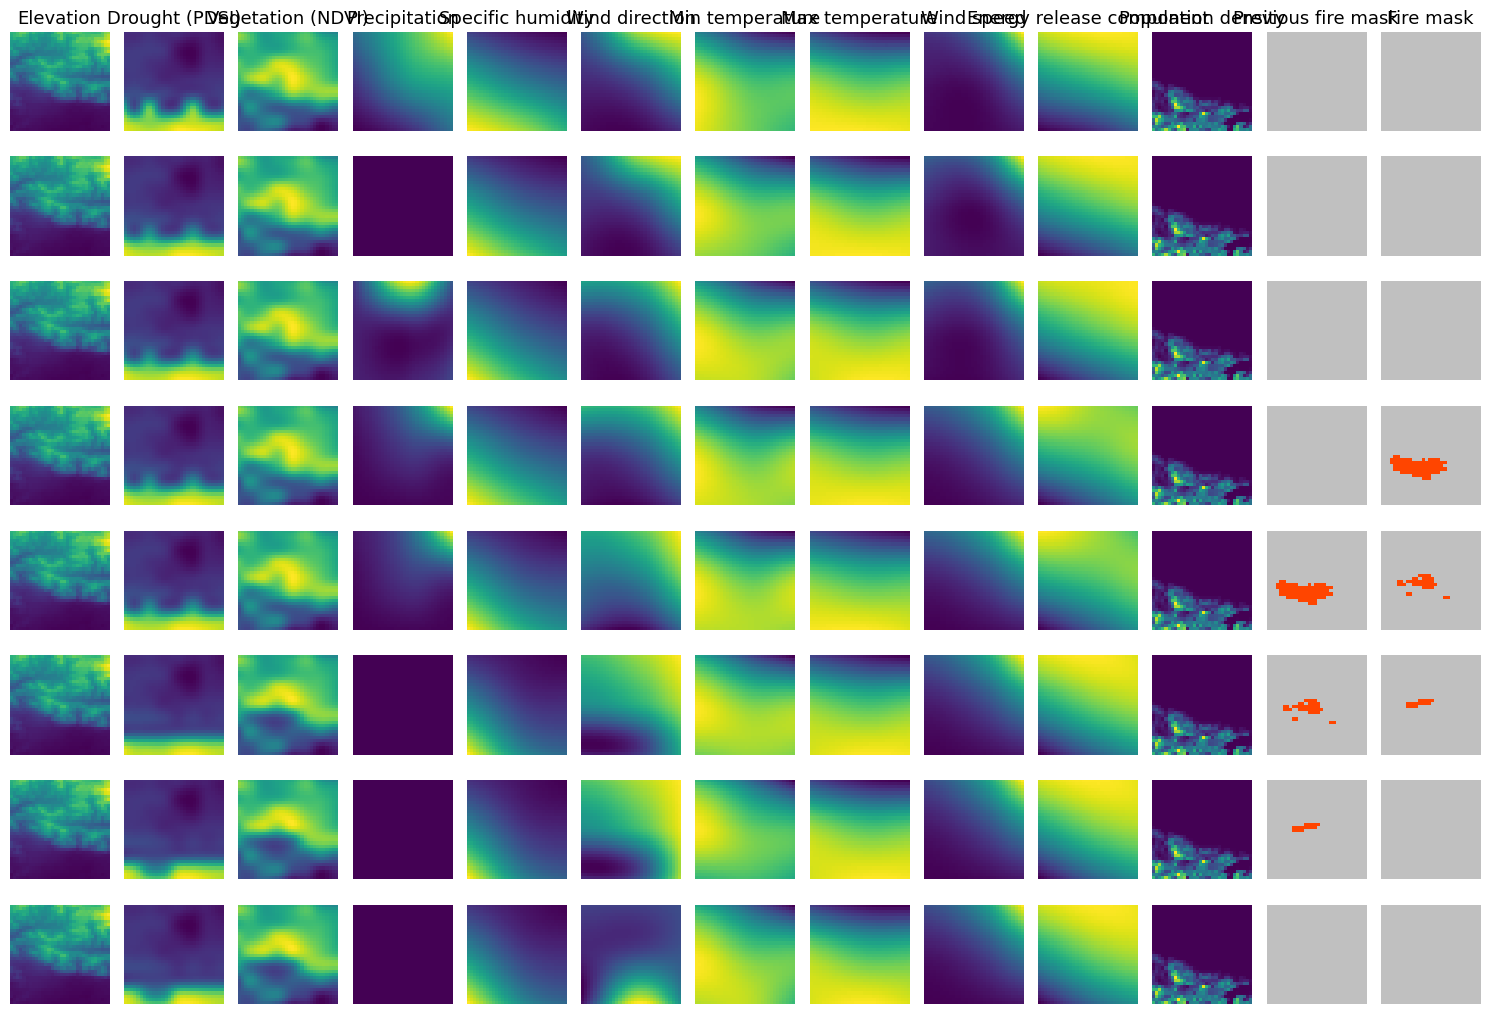

In [16]:
import image_utils

# New plotting using the shared helper from image_utils.
# This keeps the old matplotlib-based visualization (next cell)
# but provides a single, feature-aware entry point for future use.
_ = image_utils.plot_dataset(
    n_rows=23,
    inputs=inputs,
    labels=labels,
    predictions=None,
    feature_names=INPUT_FEATURES,
)
plt.show()

IndexError: list index out of range

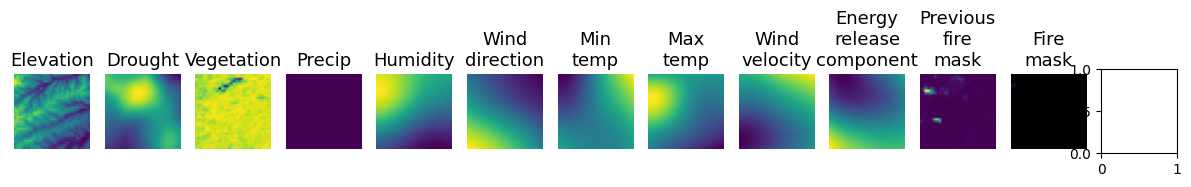

In [15]:
fig = plt.figure(figsize=(15,6.5*(23/5)))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features -  1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      im = plt.imshow(inputs[i, :, :, -1], cmap='inferno', vmin=0, vmax=9)
    if j == n_features:
      im = plt.imshow(labels[i, :, :, 0], cmap='inferno', vmin=0, vmax=9) 
    plt.axis('off')
plt.tight_layout()

# Add colorbar for the inferno colormap
cbar = fig.colorbar(im, ax=fig.axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Fire Intensity', rotation=270, labelpad=15)
